# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier  # Ensure you have xgboost installed
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Loading the Files

Download the csv files into the `data/` directory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
trainingSet = pd.read_csv("/content/drive/My Drive/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
#print()

#print(trainingSet.head())
#print()
#print(testingSet.head())

#print()

#print(trainingSet.describe())

#trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
#plt.show()

#print()
#print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)


# Adding Features

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


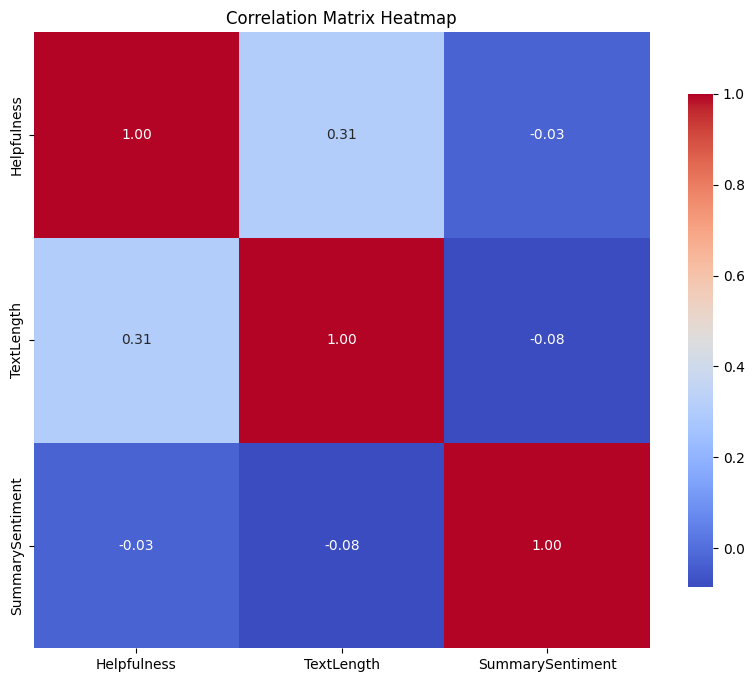

In [5]:
nltk.download('vader_lexicon')

def add_features_to(df):
    # This is where you can do all your feature extraction
    sia = SentimentIntensityAnalyzer()


    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['TextLength'] = df['Text'].fillna('').str.len()
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


    #df['Text_sentiment_scores'] = df['Text'].apply(sia.polarity_scores)
    #df['Sum_sentiment_scores'] = df['Summary'].apply(sia.polarity_scores)


    return df

# Load the feature extracted files if they've already been generated
if exists('/content/drive/My Drive/X_train.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/X_train.csv")
if exists('/content/drive/My Drive/X_submission.csv'):
    X_submission = pd.read_csv("/content/drive/My Drive/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./drive/MyDrive/X_train.csv", index=False)
    X_train.to_csv("./drive/MyDrive/X_submission.csv", index=False)

# Sample + Split into training and testing set

In [ ]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [ ]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'TextLength', 'SummarySentiment']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [ ]:
# Learn the model
print(Y_train)

model = KNeighborsClassifier(n_neighbors=100).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

131283     5.0
1202017    2.0
511808     1.0
955172     4.0
735507     5.0
          ... 
152315     5.0
963395     4.0
117952     5.0
1484405    5.0
305711     4.0
Name: Score, Length: 1114005, dtype: float64


# Model Evaluation

Accuracy on testing set =  0.5464404205355796


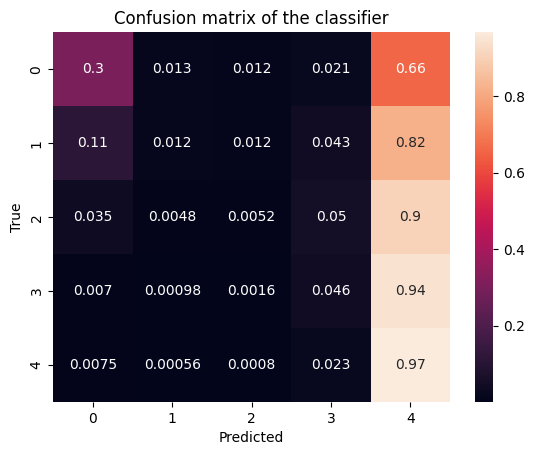

In [ ]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [ ]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./drive/MyDrive/submission.csv", index=False)